### Problem 1 | K-NN Classifier
Given the MAGIC gamma telescope dataset. This dataset is generated to simulate registration of high
energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging
technique. The dataset consists of two classes: gammas (signal) and hadrons (background). There are
12332 gamma events and 6688 hadron events

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [22]:
data = pd.read_csv("magic04.data", header=None)

# print(data.head())

hadrons_data = data[data.iloc[:, -1] == 'h']
gamma_data = data[data.iloc[:, -1] == 'g'].sample(n=hadrons_data.shape[0], random_state=1)

combined_data = pd.concat([gamma_data, hadrons_data], ignore_index=True)


In [23]:
training_data, temp_data = train_test_split(combined_data, test_size=0.3, random_state=1)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

x_training_data = training_data.iloc[:, :-1]
y_training_data = training_data.iloc[:, -1]
x_validation_data = validation_data.iloc[:, :-1]
y_validation_data = validation_data.iloc[:, -1]
x_test_data = test_data.iloc[:, :-1]
y_test_data = test_data.iloc[:, -1]


In [24]:
scaler = StandardScaler()
x_training_data = scaler.fit_transform(x_training_data)
x_validation_data = scaler.transform(x_validation_data)
x_test_data = scaler.transform(x_test_data)


In [25]:
k_metrics = {}

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_training_data, y_training_data)
    y_predictions = knn.predict(x_validation_data)
    accuracy = accuracy_score(y_validation_data, y_predictions)
    precision = precision_score(y_validation_data, y_predictions, pos_label='g')
    recall = recall_score(y_validation_data, y_predictions, pos_label='g')
    f1 = f1_score(y_validation_data, y_predictions, pos_label='g')
    conf_matrix = confusion_matrix(y_validation_data, y_predictions)
    k_metrics[k] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

best_k = max(k_metrics, key=lambda x: (k_metrics[x]['f1_score'], k_metrics[x]['accuracy']))
best_metrics = k_metrics[best_k]

print(f"\nBest k value based on F1-score (and accuracy if F1-scores are equal): k={best_k}")
print(f"Accuracy={best_metrics['accuracy']:.2f}")
print(f"Precision={best_metrics['precision']:.2f}")
print(f"Recall={best_metrics['recall']:.2f}")
print(f"F1 Score={best_metrics['f1_score']:.2f}")
print(f"Confusion Matrix:\n{best_metrics['confusion_matrix']}")



Best k value based on F1-score (and accuracy if F1-scores are equal): k=13
Accuracy=0.83
Precision=0.79
Recall=0.90
F1 Score=0.84
Confusion Matrix:
[[925 108]
 [241 732]]


In [26]:
x_train_validation = pd.concat([pd.DataFrame(x_training_data), pd.DataFrame(x_validation_data)], ignore_index=True)
y_train_validation = pd.concat([y_training_data, y_validation_data], ignore_index=True)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_validation, y_train_validation)

y_test_predictions = best_knn.predict(x_test_data)
test_accuracy = accuracy_score(y_test_data, y_test_predictions)
test_precision = precision_score(y_test_data, y_test_predictions, pos_label='g')
test_recall = recall_score(y_test_data, y_test_predictions, pos_label='g')
test_f1 = f1_score(y_test_data, y_test_predictions, pos_label='g')
test_conf_matrix = confusion_matrix(y_test_data, y_test_predictions)

print("\nTEST DATA METRICS")
print(f"Accuracy={test_accuracy:.2f}")
print(f"Precision={test_precision:.2f}")
print(f"Recall={test_recall:.2f}")
print(f"F1 Score={test_f1:.2f}")
print(f"Confusion Matrix:\n{test_conf_matrix}")


TEST DATA METRICS
Accuracy=0.81
Precision=0.76
Recall=0.89
F1 Score=0.82
Confusion Matrix:
[[873 103]
 [280 751]]


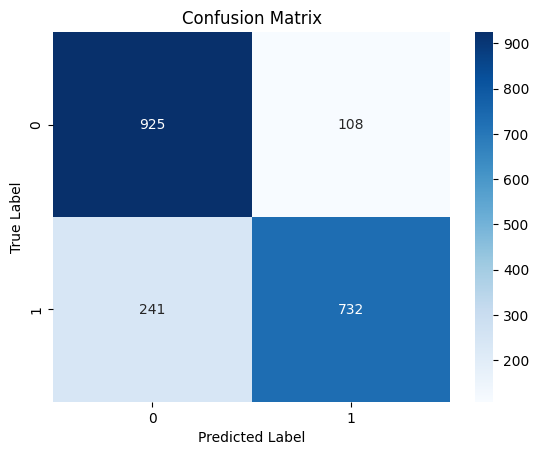

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(best_metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


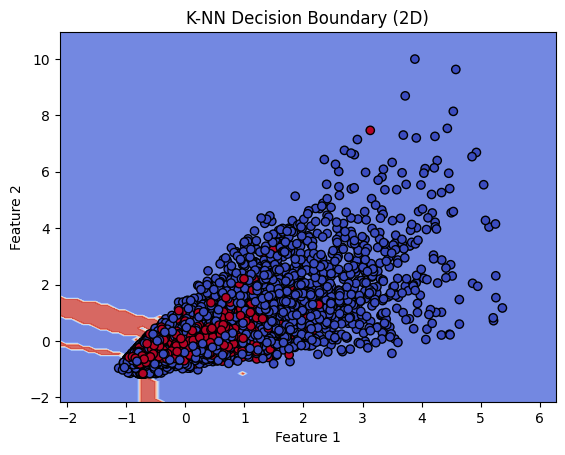

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Convert labels 'g' and 'h' to numeric (g -> 1, h -> 0)
y_training_data_numeric = y_training_data.replace({'g': 1, 'h': 0})

# Select two features for 2D visualization (e.g., the first two columns)
X_train_2d = x_training_data[:, :2]

# Train the K-NN model on the reduced 2D data
knn_2d = KNeighborsClassifier(n_neighbors=best_k)
knn_2d.fit(X_train_2d, y_training_data_numeric)

# Create mesh grid for plotting the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the grid
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

# Plot the original data points
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_training_data_numeric, edgecolors='k', cmap='coolwarm')
plt.title('K-NN Decision Boundary (2D)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
